#### 1. Обучить любую модель классификации на датасете IRIS до применения PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.
#### 2. *Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

#### 1 - 2

Используем наш случайный лес из прошлых лекций в качестве модели классификации

In [2]:
# Генерация N-бутстрап выборок


def get_bootstrap(data, labels, N):
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Оценка качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
    return forest

In [12]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

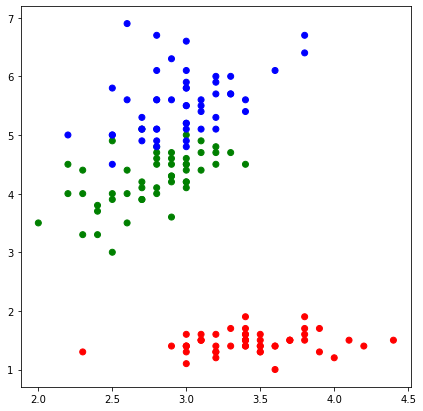

In [16]:
X, y = load_iris(return_X_y=True)
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=cmap)

Разобьём нашу выборку на трейн и тест, и посмотрим точность модели на исходных данных:

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
my_forest = random_forest(X_train, y_train, 15)
y_pred = tree_vote(my_forest, X_test)
accuracy_metric(y_test, y_pred)

97.77777777777777

Преобразуем наши исходные данные, выделив 3 главные компоненты из 4 признаков.

*Но для начала реализуем 2-е задание и используем свою реализацию метода главных компонент с помощью сингулярного разложения.*

In [19]:
class MySVD:
    
    #инициируем метод с указанием количества компонент, которые будут использованы в итоговом датасете(n_comp, по умолчанию-все)
    #и указанием необходимости центрирования данных(по умолчанию - центрируем)
    def __init__(self,n_comp: int=None, centr: bool=True):    
        self.n_comp = n_comp
        self.centr = centr
    
    #обучение
    def fit(self, X):
        if not self.n_comp:
            self.n_comp = X.shape[1]
        self.X_centr = (X-np.mean(X, axis=0))/np.std(X, axis=0) if self.centr else X.copy()
        self.u,self.s,self.vh = np.linalg.svd(self.X_centr, full_matrices=False) #сингулярное разложение матрицы признаков
        self.W = self.vh.T[:,:self.n_comp]  #нахождение матрицы весов        
    
    def transform(self):
        x_trans = self.X_centr@self.W
        return x_trans
    
    # доля объясненной дисперсии
    def var_exp(self):
        eig_sum = sum(self.s)
        var_exp = [(i / eig_sum) * 100 for i in self.s]
        return var_exp
    
    # накопленная объясненная дисперсия
    def cum_var_exp(self):        
        eig_sum = sum(self.s)
        var_exp = [(i / eig_sum) * 100 for i in self.s]
        return np.cumsum(var_exp)
    
    # сингулярные числа
    def sing_nums(self):
        return self.s

*Продолжим выполнение первого задания:*

In [20]:
my_svd = MySVD(n_comp=3)
my_svd.fit(X)
X_trans = my_svd.transform()

In [21]:
X_train_trans, X_test_trans, y_train_trans, y_test_trans = model_selection.train_test_split(X_trans, y, test_size=0.3, random_state=42)

In [22]:
my_forest_trans=random_forest(X_train_trans, y_train_trans, 20)
y_pred_trans = tree_vote(my_forest_trans, X_test_trans)
accuracy_metric(y_test_trans, y_pred_trans)

82.22222222222221

Как можно заметить, есть снижение точности при использовании 3 компонент, которое связано с тем, что первые три компоненты объясняют 95,5% дисперсии данных.

In [23]:
my_svd.cum_var_exp()

array([ 53.52971788,  83.48653067,  95.49021308, 100.        ])

In [24]:
my_svd.sing_nums()

array([20.92306556, 11.7091661 ,  4.69185798,  1.76273239])

In [25]:
my_svd.var_exp()

[53.52971788236241, 29.95681278402008, 12.003682417209484, 4.509786916408035]